<a href="https://colab.research.google.com/github/MeowJ/Generative-Adversarial-Network/blob/master/DCGAN%2BMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model
from keras import backend as K

Using TensorFlow backend.


#### Getting the data

In [0]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


#### Explore visual data

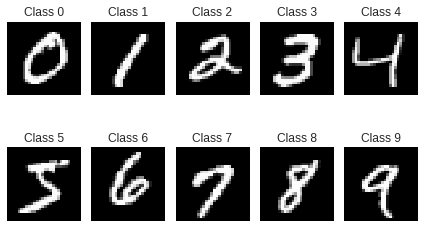

In [0]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

In [0]:
print('X_train.shape', X_train.shape)

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

print('X_train reshape:', X_train.shape)

X_train.shape (60000, 28, 28)
X_train reshape: (60000, 28, 28, 1)


In [0]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# FC: 7x7x256
generator.add(Dense(7*7*128, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(Reshape((7, 7, 128)))

# Conv 1: 14x14x128
generator.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU(0.2))

# Conv 2: 28x28x64
generator.add(Conv2DTranspose(32, kernel_size=3, strides=1, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU(0.2))

# # Conv 3: 28x28x32
# generator.add(Conv2DTranspose(32, kernel_size=3, strides=1, padding='same'))
# generator.add(BatchNormalization(momentum=0.8))
# generator.add(ReLU(0.2))

# Conv 4: 28x28x1
generator.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='tanh'))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# prints a summary representation of your model
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        73792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 32)        18464     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 32)        128       
__________

In [0]:
# Discriminator network
discriminator = Sequential()

# Conv 1: 14x14x64
discriminator.add(Conv2D(32, kernel_size=3, strides=2, padding='same',
                         input_shape=(28, 28, 1), kernel_initializer=init))
discriminator.add(LeakyReLU(0.2))

# Conv 2:
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(0.2))

# FC
discriminator.add(Flatten())

# Output
discriminator.add(Dense(1, activation='sigmoid'))

In [0]:
# prints a summary representation of your model
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 128)         512       
__________

In [0]:
# Optimizer
optimizer = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [0]:
discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

d_g.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [0]:
# prints a summary representation of your model
d_g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         726401    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 95489     
Total params: 821,890
Trainable params: 726,209
Non-trainable params: 95,681
_________________________________________________________________


Instructions for updating:
Use tf.cast instead.
epoch = 1/100, d_loss=0.001, g_loss=7.694                                                                                                     


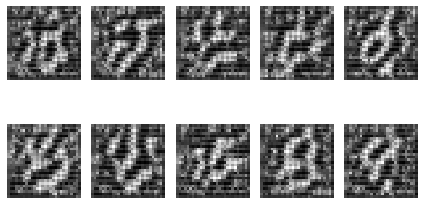

epoch = 2/100, d_loss=0.016, g_loss=6.089                                                                                                     
epoch = 3/100, d_loss=0.109, g_loss=14.390                                                                                                     
epoch = 4/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 5/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 6/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 7/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 8/100, d_loss=8.059, g_loss=16.118                                                                                               

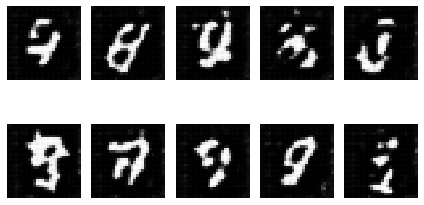

epoch = 12/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 13/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 14/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 15/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 16/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 17/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 18/100, d_loss=8.059, g_loss=16.118                                                                                       

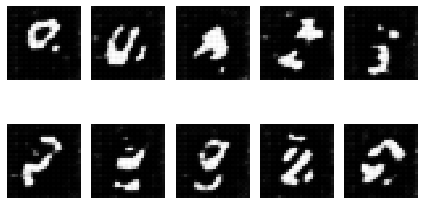

epoch = 22/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 23/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 24/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 25/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 26/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 27/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 28/100, d_loss=8.059, g_loss=16.118                                                                                       

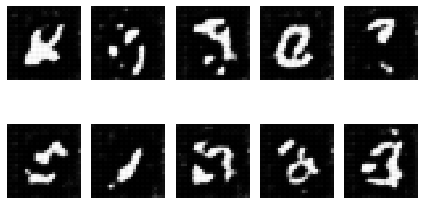

epoch = 32/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 33/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 34/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 35/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 36/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 37/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 38/100, d_loss=8.059, g_loss=16.118                                                                                       

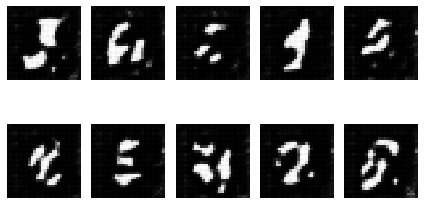

epoch = 42/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 43/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 44/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 45/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 46/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 47/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 48/100, d_loss=8.059, g_loss=16.118                                                                                       

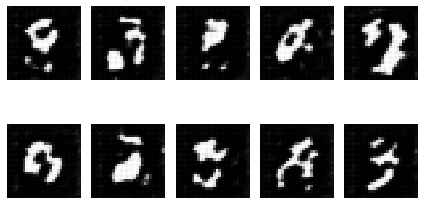

epoch = 52/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 53/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 54/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 55/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 56/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 57/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 58/100, d_loss=8.059, g_loss=16.118                                                                                       

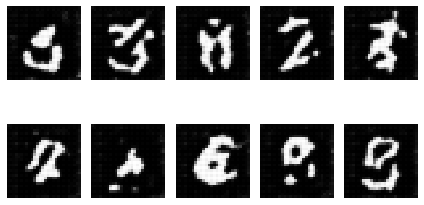

epoch = 62/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 63/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 64/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 65/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 66/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 67/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 68/100, d_loss=8.059, g_loss=16.118                                                                                       

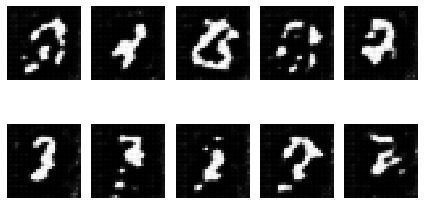

epoch = 72/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 73/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 74/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 75/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 76/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 77/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 78/100, d_loss=8.059, g_loss=16.118                                                                                       

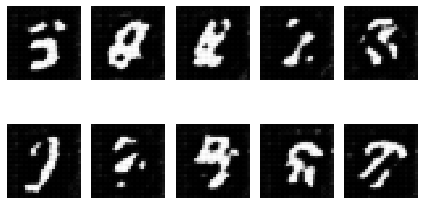

epoch = 82/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 83/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 84/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 85/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 86/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 87/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 88/100, d_loss=8.059, g_loss=16.118                                                                                       

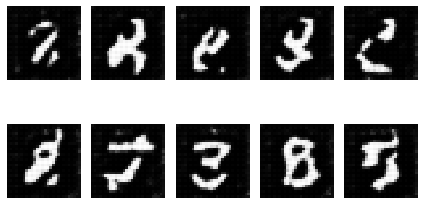

epoch = 92/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 93/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 94/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 95/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 96/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 97/100, d_loss=8.059, g_loss=16.118                                                                                                     
epoch = 98/100, d_loss=8.059, g_loss=16.118                                                                                       

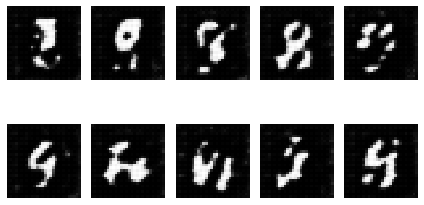

In [0]:
epochs = 100
batch_size = 64
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch, y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        d_g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


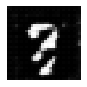

In [0]:
#plot single picture
samples = 1
x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))
d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)

for k in range(samples):
  
  plt.subplot(2, 5, k+1)
  
  plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
  plt.xticks([])
  plt.yticks([])

plt.tight_layout()
plt.show()


### 5. Evaluate model

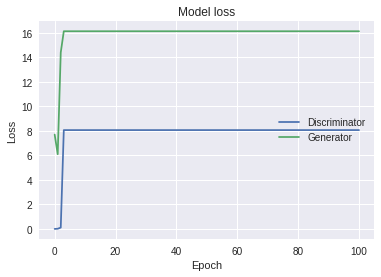

In [0]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Generator'], loc='center right')
plt.show()